In [19]:
# Enable autoreload for development
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# Setup
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [21]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [22]:
# Load and clean data
from src.load_data import load_data

In [23]:
df = load_data()
df

,No.,Diameter (mm),Speed (rpm),Feed (mm/rev),Thrust force (N),Torque (Nm),Flank wear (mm),Workpiece
0,1,9.0,500,0.13,1088.1,10.67,0.10,cast iron
1,2,9.0,500,0.18,1435.1,14.66,0.13,cast iron
2,3,9.0,500,0.25,1588.3,16.04,0.06,cast iron
3,4,9.0,500,0.36,1669.8,17.12,0.09,cast iron
4,5,9.0,400,0.13,1150.9,11.22,0.12,cast iron
...,...,...,...,...,...,...,...,...
160,161,10.0,1000,0.50,1960.0,18.13,0.13,copper
161,162,7.5,1000,0.50,784.0,7.35,0.10,copper
162,163,5.0,1000,0.50,651.0,6.17,0.07,copper
163,164,10.0,1000,0.71,2009.0,20.58,0.17,copper


In [24]:
from src.clean_data import clean_dataset, add_features
df_clean = clean_dataset(df)

In [25]:
# from src.outlier_handling import cap_outliers_iqr

# # Now this will work correctly
# df_clean = cap_outliers_iqr(df_clean, 'thrust_force_(n)', multiplier=1.0)


In [26]:
# print(f"Updated shape after outlier removal: {df_clean.shape}")

In [27]:
df_clean = add_features(df_clean)  # ⬅️ Feature Engineering : this includes new features

In [28]:
# Identify one-hot workpiece columns (e.g., 'workpiece_b', 'workpiece_c', etc.)
workpiece_cols = [col for col in df_clean.columns if col.startswith('workpiece_')]

In [29]:
# Confirm all required columns exist
print("Cleaned Columns:", df_clean.columns.tolist())

Cleaned Columns: ['no.', 'diameter_(mm)', 'speed_(rpm)', 'feed_(mm/rev)', 'thrust_force_(n)', 'torque_(nm)', 'flank_wear_(mm)', 'workpiece_copper', 'workpiece_mild steel', 'speed_per_dia', 'log_feed', 'torque_feed_ratio', 'material_hardness', 'feed_squared', 'speed_squared']


In [30]:
df_clean.shape

(164, 15)

In [31]:
# Features and targets
X = df_clean[['diameter_(mm)', 'speed_(rpm)', 'feed_(mm/rev)',
              'speed_per_dia', 'log_feed',
              'torque_feed_ratio', 'material_hardness',
              'feed_squared', 'speed_squared'] + workpiece_cols]
import numpy as np
# Target transformation: log-transform all 3 targets
y = df_clean[['thrust_force_(n)', 'torque_(nm)', 'flank_wear_(mm)']].copy()

# Log-transform each to handle skewness and stabilize variance
for col in y.columns:
    y[col] = np.log1p(y[col])  # log1p avoids issues with zeros

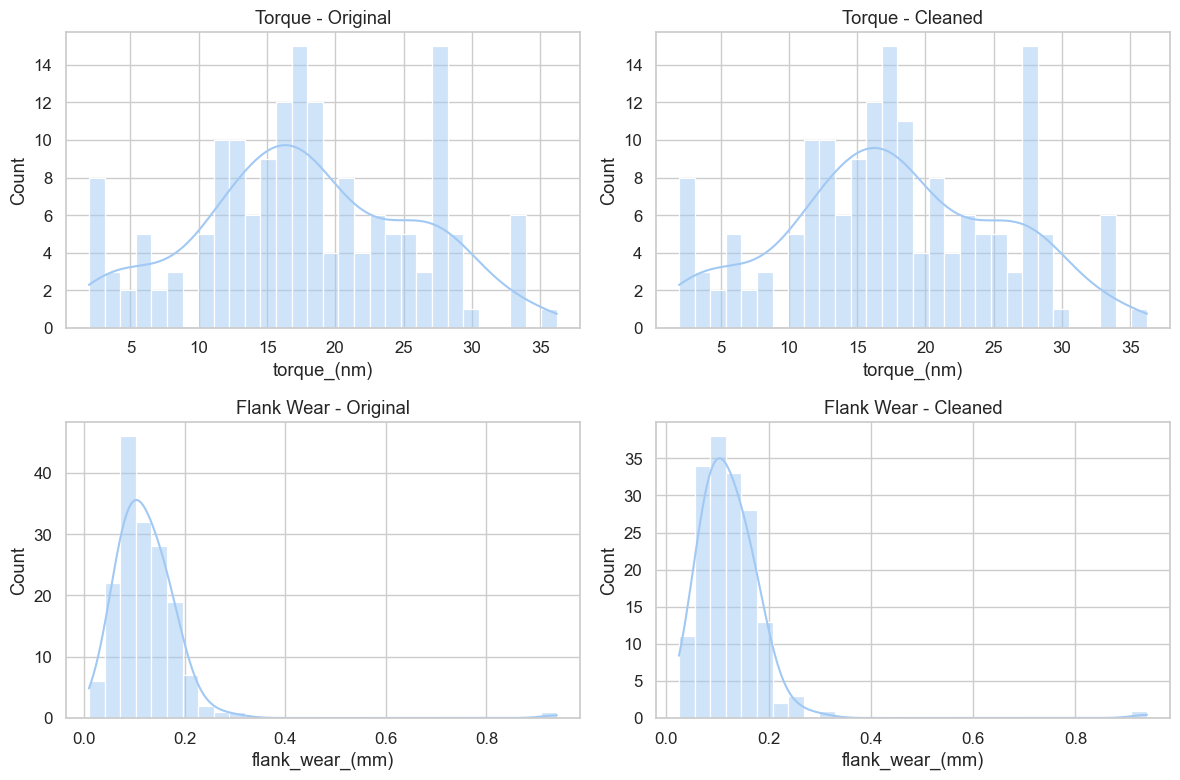

In [32]:
# Visualize distributions before and after cleaning
df_orig = load_data()
df_orig.columns = df_orig.columns.str.strip().str.lower().str.replace(' ', '_')

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df_orig['torque_(nm)'], bins=30, ax=axs[0,0], kde=True)
axs[0,0].set_title("Torque - Original")

sns.histplot(df_clean['torque_(nm)'], bins=30, ax=axs[0,1], kde=True)
axs[0,1].set_title("Torque - Cleaned")

sns.histplot(df_orig['flank_wear_(mm)'], bins=30, ax=axs[1,0], kde=True)
axs[1,0].set_title("Flank Wear - Original")

sns.histplot(df_clean['flank_wear_(mm)'], bins=30, ax=axs[1,1], kde=True)
axs[1,1].set_title("Flank Wear - Cleaned")

plt.tight_layout()
plt.show()

Interpretation: (a)Torque values seem to follow a roughly normal distribution with no significant outliers.
(b)Flank wear had outliers or noise at the high end, which were removed during cleaning.

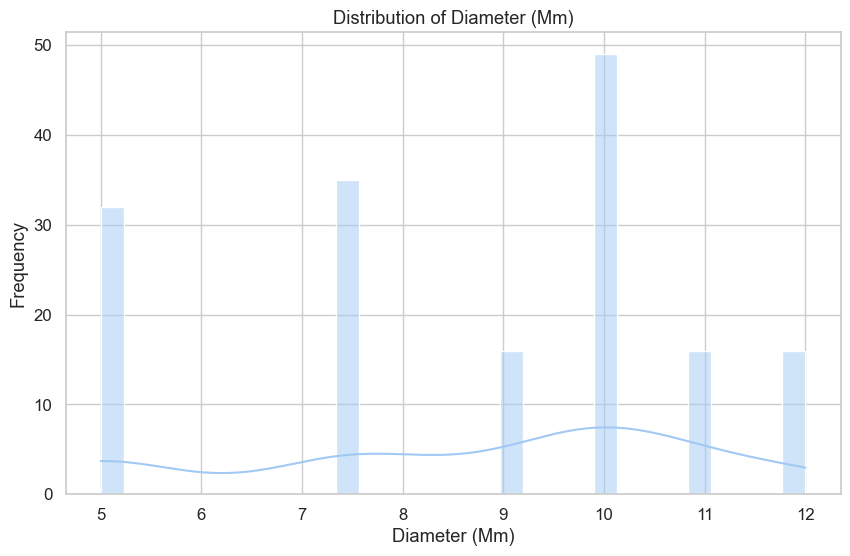

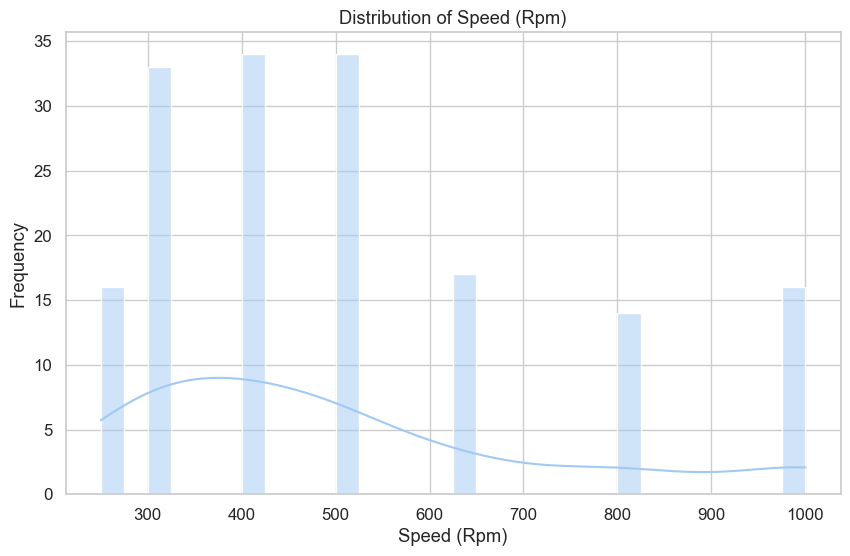

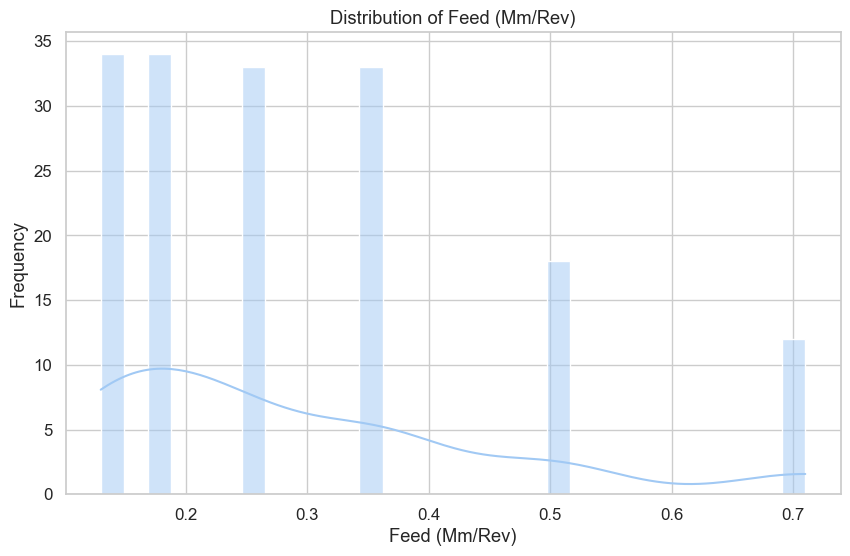

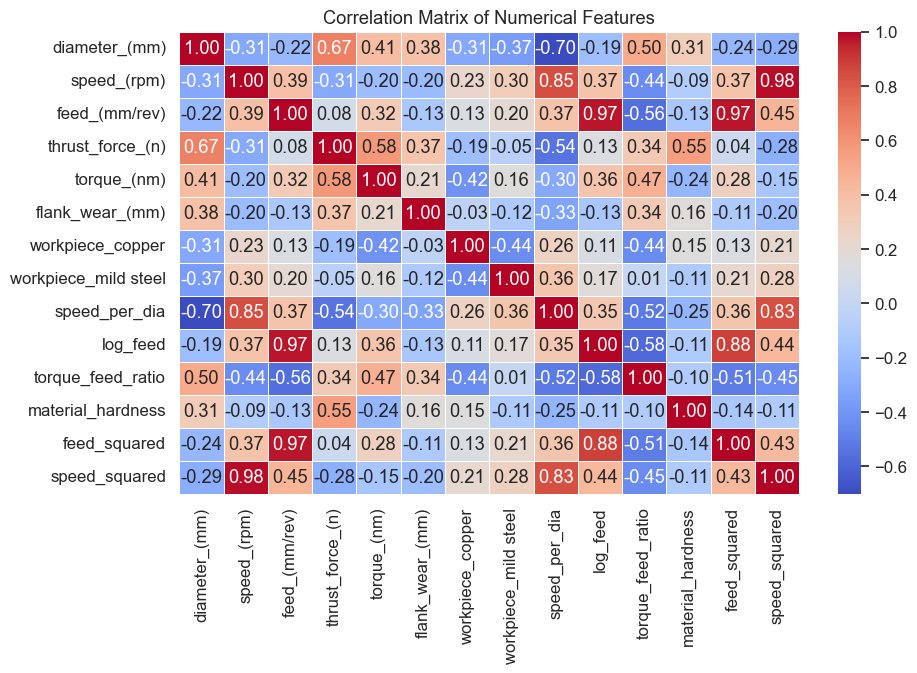

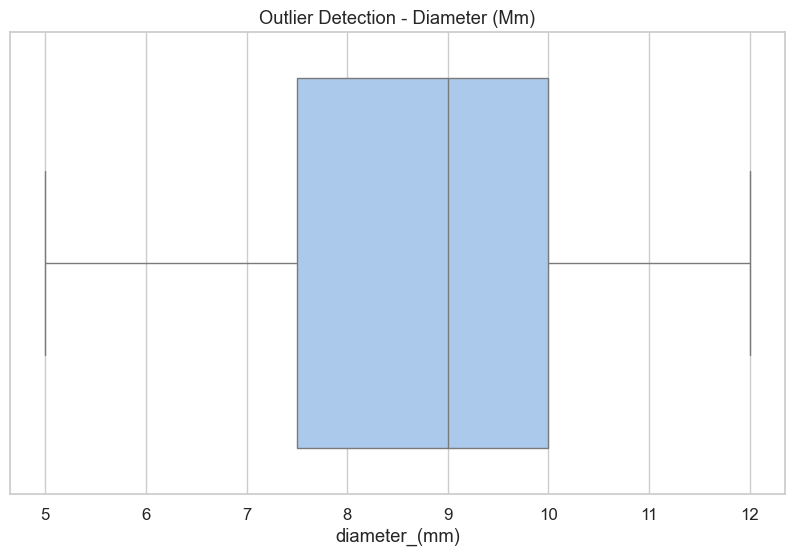

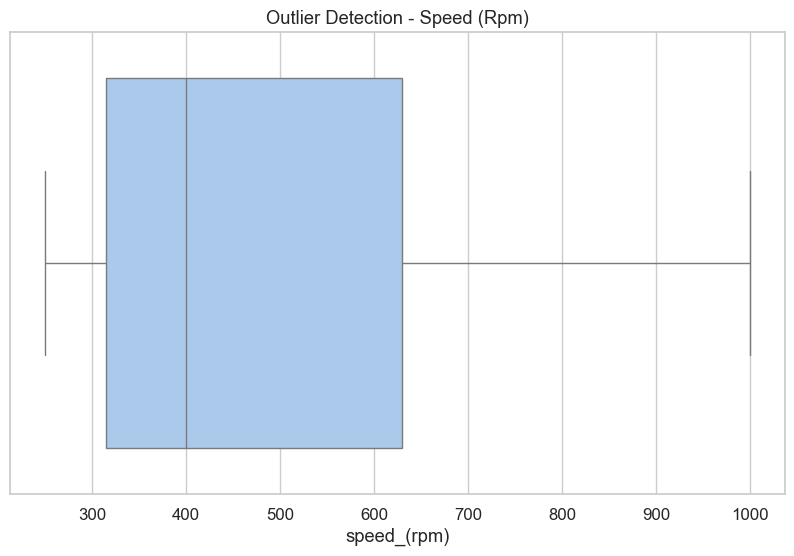

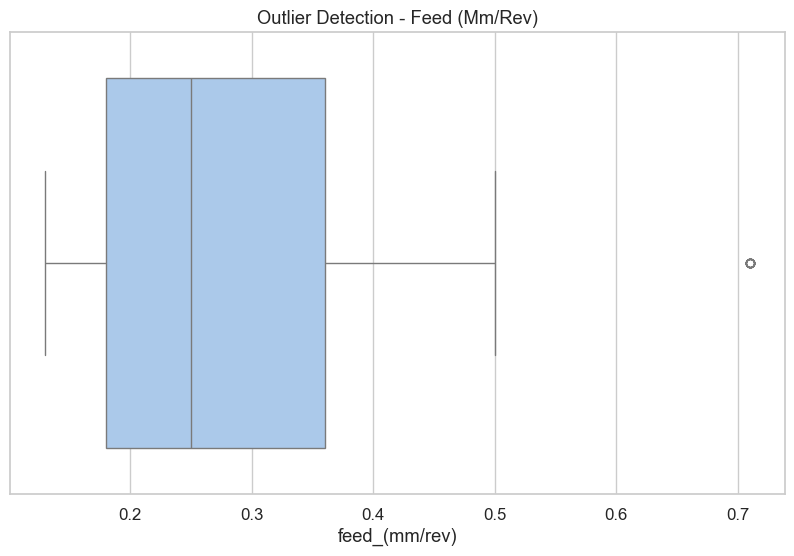

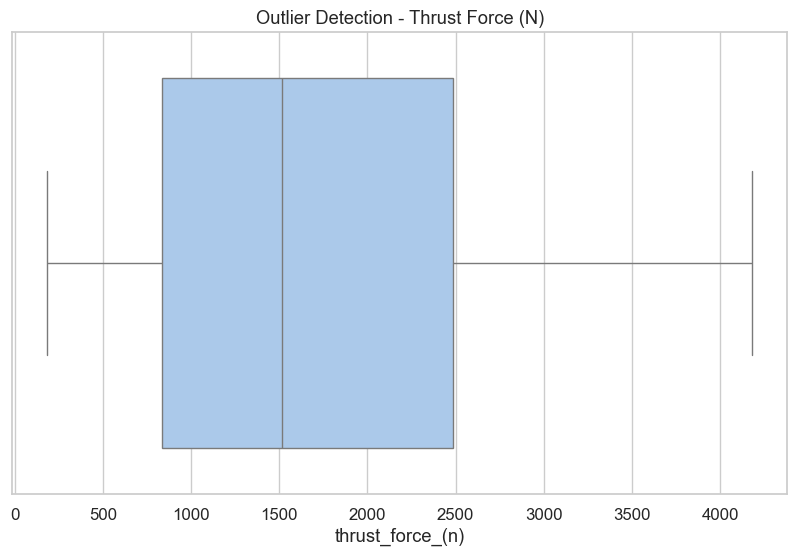

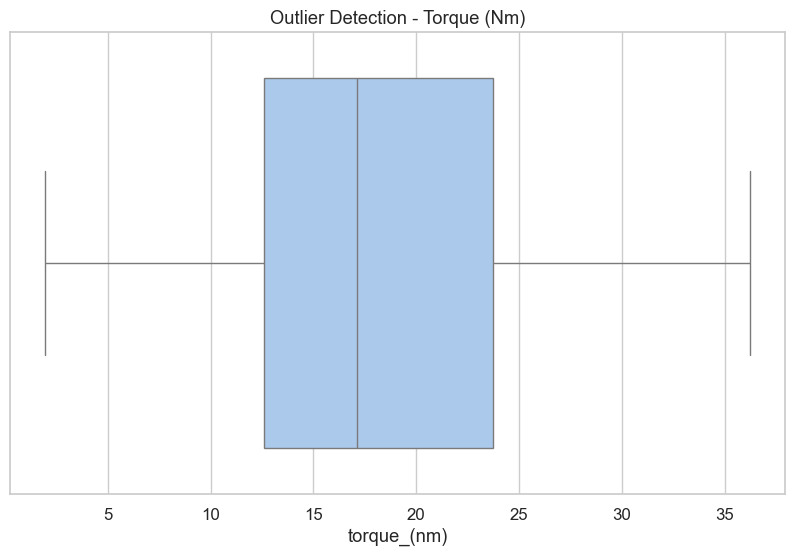

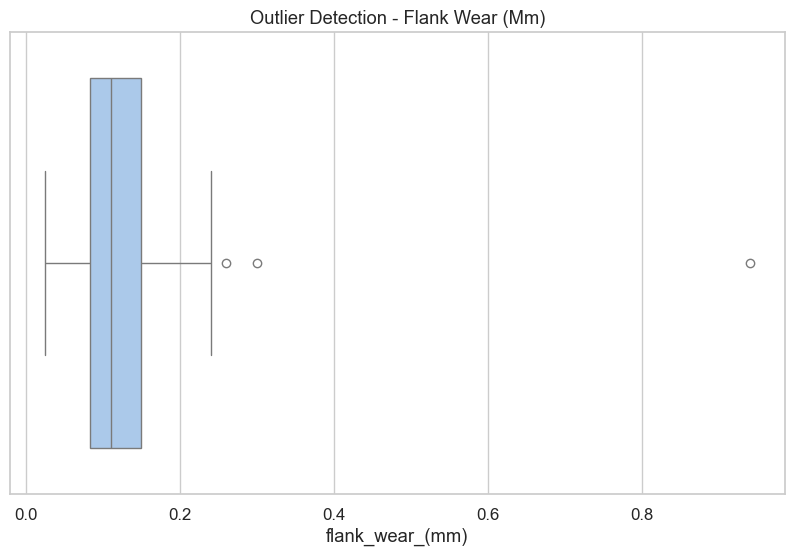

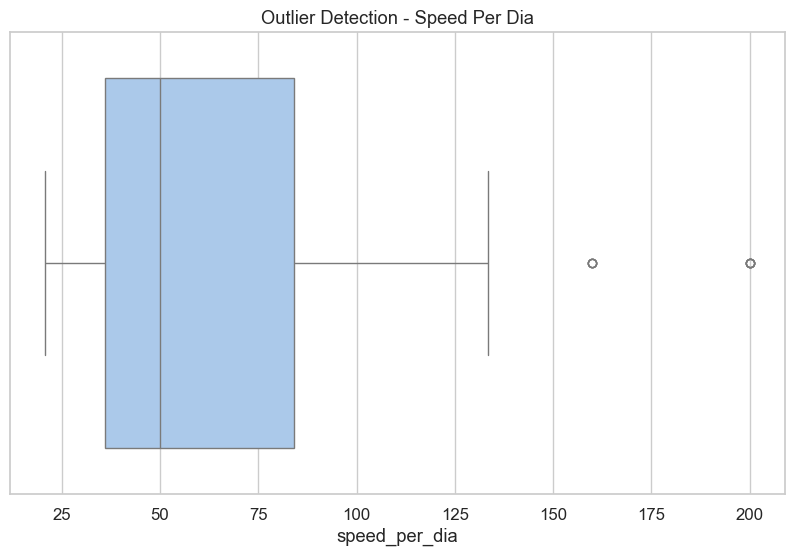

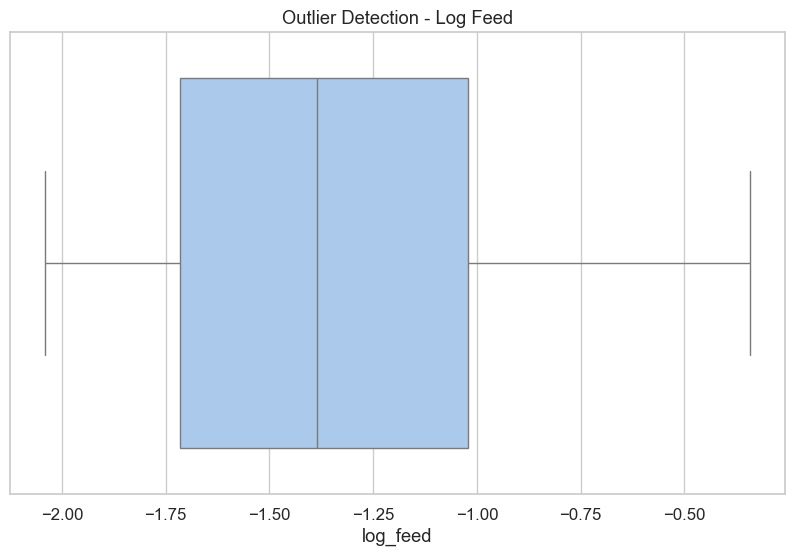

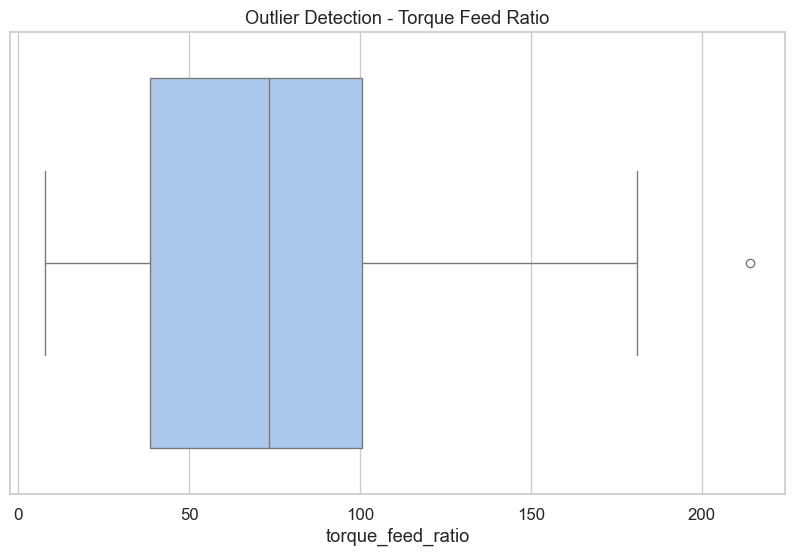

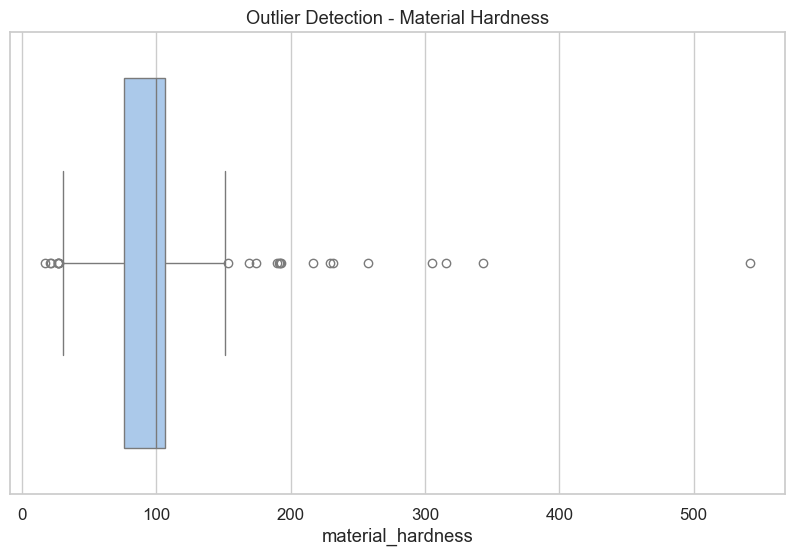

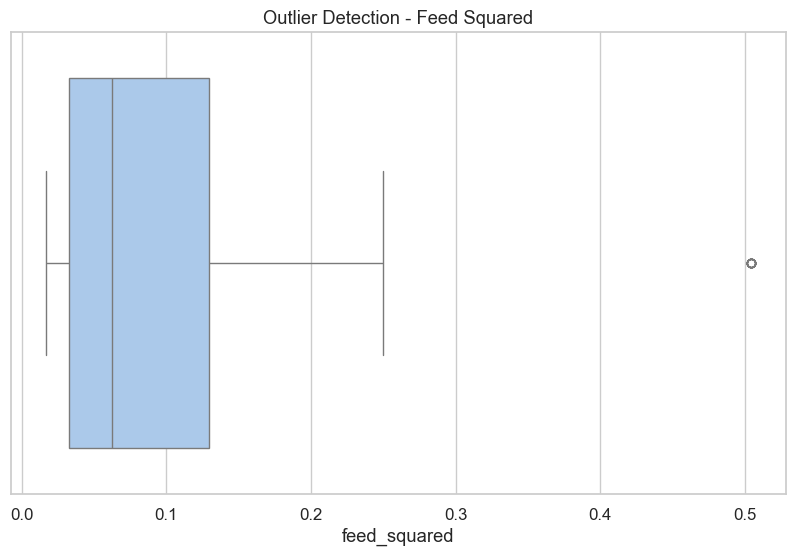

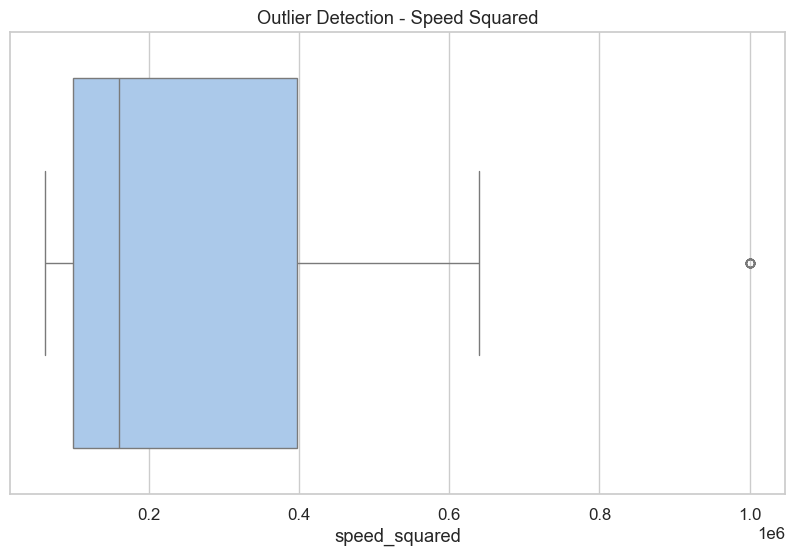

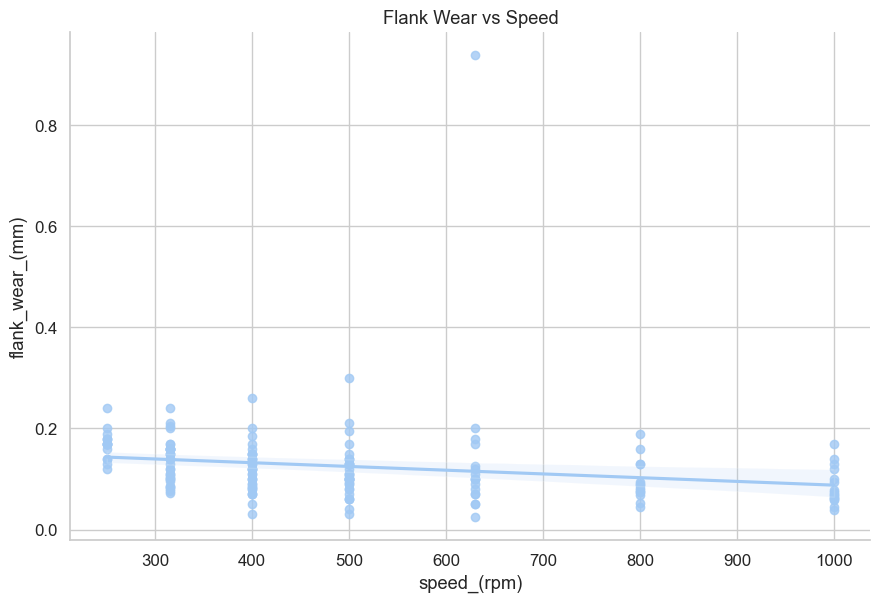

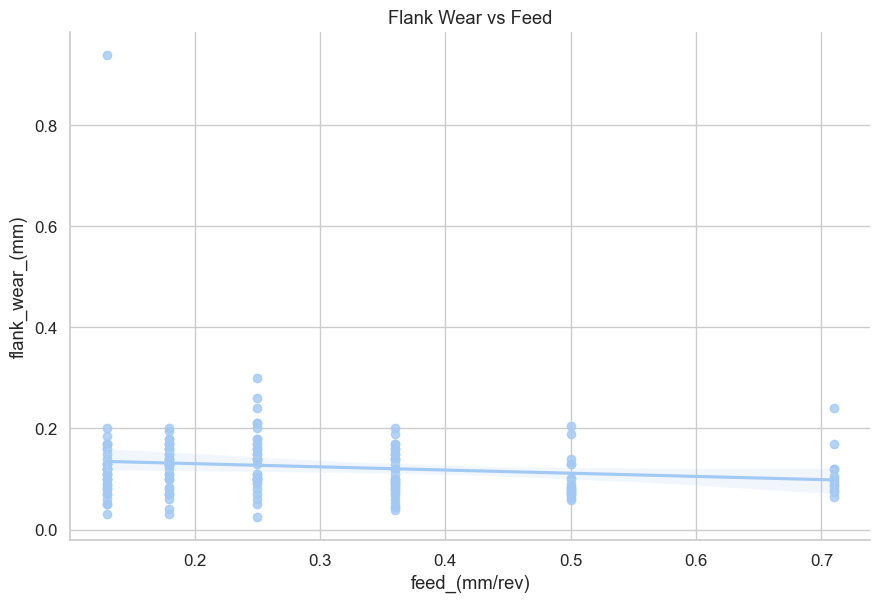

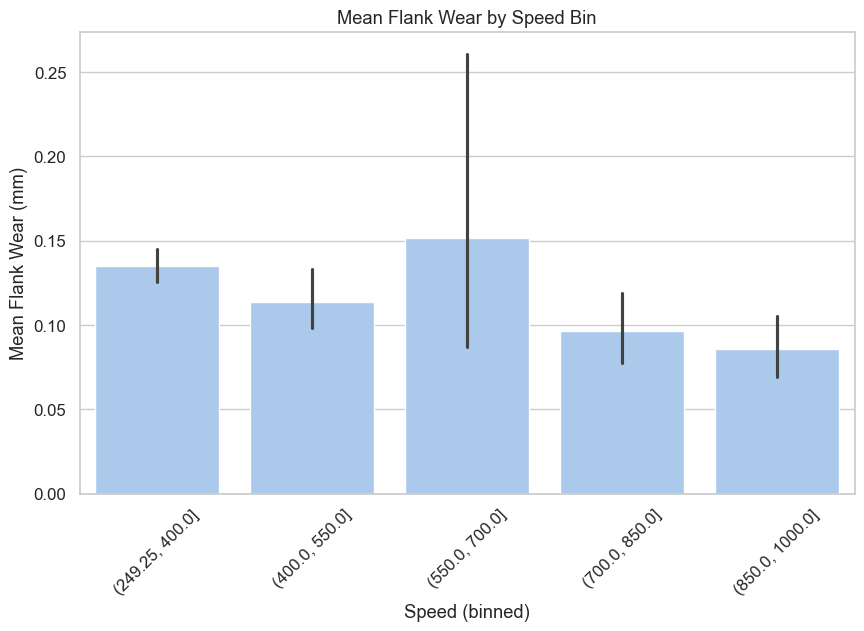

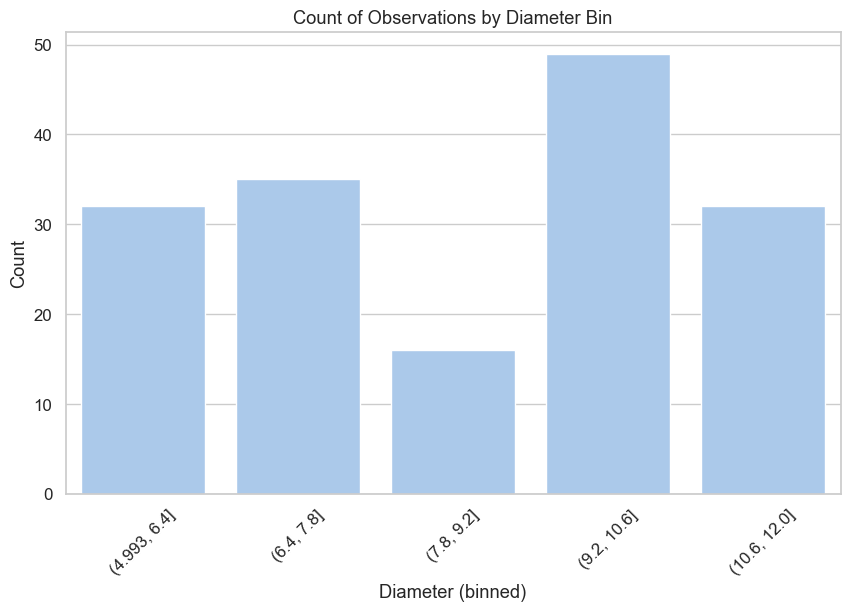

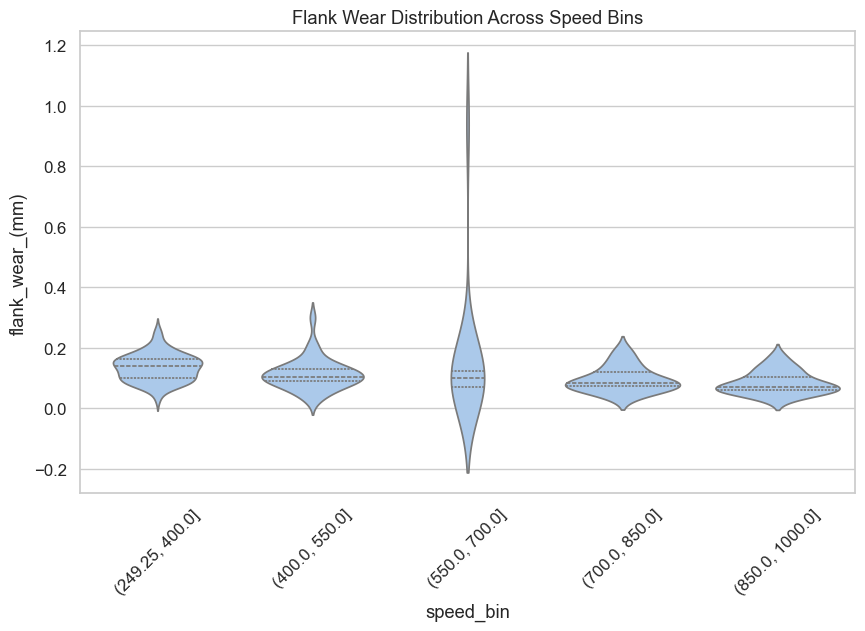

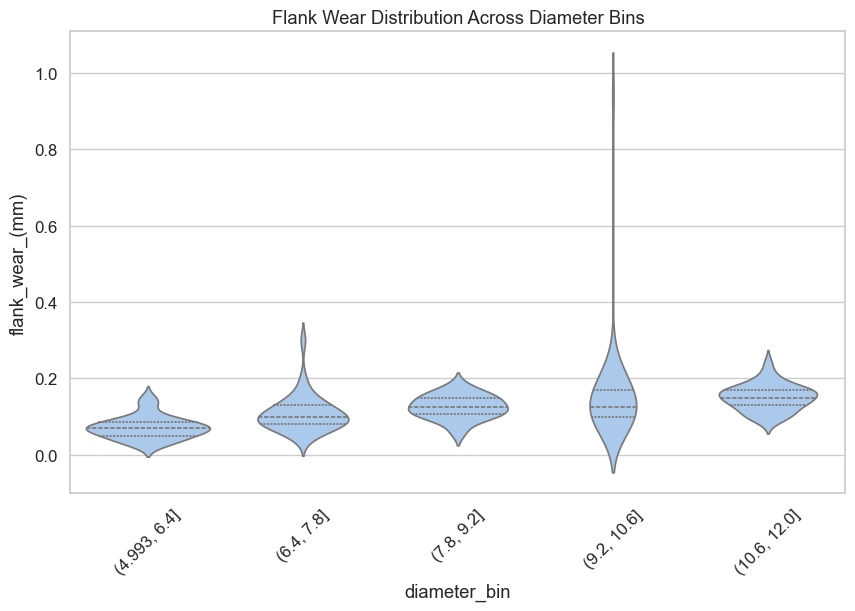

In [33]:
# General visualizations
from src.visualise_data import visualize
visualize(df_clean)

In [34]:
# Model tuning
from src.tune_models import tune_random_forest
best_rf, best_params, cv_results = tune_random_forest(X, y)
print("Best Params:", best_params)

import pandas as pd
cv_df = pd.DataFrame(cv_results)
cv_df = cv_df.sort_values(by='mean_test_score', ascending=False)
cv_df[['params', 'mean_test_score', 'rank_test_score']].head()

Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}


,params,mean_test_score,rank_test_score
28,"{'max_depth': 10, 'max_features': 'log2', 'min...",0.018316,1
19,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",0.018316,1
0,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.015380,3
45,"{'max_depth': 20, 'max_features': 'log2', 'min...",0.015380,3
9,"{'max_depth': None, 'max_features': 'log2', 'm...",0.015380,3


In [35]:
# Model training and evaluation
from src.model_train import train_models
results = train_models(X, y)

In [ ]:
X_test = results['X_test']
y_test_log = results['y_test_log']       # still in log-scale
y_test_orig = results['y_test_orig']     # inverse-transformed (expm1)
models = results['models']
metrics = results['metrics']

In [38]:
# ✅ Inverse transform log-scale targets for real-world evaluation
import numpy as np
y_test_orig = np.expm1(np.clip(y_test_log.values, 0, 20))

In [39]:
y = df_clean[['thrust_force_(n)', 'torque_(nm)', 'flank_wear_(mm)']].copy()
y_log = np.log1p(y)
results = train_models(X, y_log)

In [40]:
y_test_orig = np.expm1(np.clip(results['y_test'].values, 0, 20))
y_pred_orig = np.expm1(np.clip(models['RandomForest'].predict(X_test), 0, 20))

KeyError: 'y_test'

In [ ]:
# This must come from the model training results
X_test = results['X_test']
y_test = results['y_test']  # <--- THIS is missing in your current cell
models = results['models']

In [ ]:
from src.evaluate_models import plot_predictions
import numpy as np

for model_name in models:
    print(f"🔍 Plotting for: {model_name}")

    # Predict in log-space
    y_pred_log = models[model_name].predict(X_test)

    # Inverse transform both prediction and ground truth
    y_pred_orig = np.expm1(np.clip(y_pred_log, 0, 20))
    y_test_orig = np.expm1(np.clip(y_test.values, 0, 20))

    # Plot on original scale
    plot_predictions(y_test_orig, y_pred_orig, y.columns)

In [ ]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

for model_name in models:
    print(f"\n📌 {model_name} Metrics (Original Scale):")

    # Predict in log-scale
    y_pred_log = models[model_name].predict(X_test)

    # Inverse-transform both prediction and test targets
    y_pred_orig = np.expm1(np.clip(y_pred_log, 0, 20))
    y_test_orig = np.expm1(np.clip(y_test.values, 0, 20))

    # Compute metrics for each target
    for i, target in enumerate(y.columns):
        y_true = y_test_orig[:, i]
        y_pred = y_pred_orig[:, i]

        r = np.corrcoef(y_true, y_pred)[0, 1]
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-5))) * 100

        print(f"  R     for {target}: {r:.4f}")
        print(f"  R2    for {target}: {r2:.4f}")
        print(f"  MAE   for {target}: {mae:.4f}")
        print(f"  MSE   for {target}: {mse:.4f}")
        print(f"  RMSE  for {target}: {rmse:.4f}")
        print(f"  MAPE  for {target}: {mape:.2f}%")

    print("-" * 40)

In [ ]:
import pandas as pd

rows = []

for model_name, model_metrics in metrics.items():
    for i, target in enumerate(y.columns):
        row = {
            'Model': model_name,
            'Target': target,
            'R': model_metrics.get('R', [None]*len(y.columns))[i],
            'R2': model_metrics.get('R2', [None]*len(y.columns))[i],
            'MAE': model_metrics.get('MAE', [None]*len(y.columns))[i],
            'MSE': model_metrics.get('MSE', [None]*len(y.columns))[i],
            'RMSE': model_metrics.get('RMSE', [None]*len(y.columns))[i]
        }
        rows.append(row)

summary_df = pd.DataFrame(rows)
display(summary_df.sort_values(by='Target'))

Use the following code to explicitly train model for Flankwear

In [ ]:
from src.train_flankwear import train_flankwear_model

# Call custom function with engineered features and original wear target
fw_result = train_flankwear_model(X, df_clean['flank_wear_(mm)'])

print("📌 Best Parameters:", fw_result['params'])
print("📈 Metrics for Flank Wear (Original Scale, Separate Model):")
for k, v in fw_result['metrics'].items():
    print(f"{k}: {v:.4f}")

In [ ]:

from src.knn_model import train_knn_model

knn_results = train_knn_model(X, y)

print("📊 KNN Metrics for Each Target:")
for name, values in zip(y.columns, zip(*knn_results['metrics'].values())):
    print(f"\n{name}")
    print(f"R2: {values[0]:.4f}")
    print(f"MAE: {values[1]:.4f}")
    print(f"MSE: {values[2]:.4f}")
    print(f"RMSE: {values[3]:.4f}")
    print(f"MAPE: {values[4]:.2f}%")